<a href="https://colab.research.google.com/github/j28905/TensorFlow/blob/main/tf_images_flores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar librerias

In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
print(tf.__version__)


2.8.0


Descargamos un dataset de imagenes de flores

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 1s 0us/step


tenemos 3670 imagenes, se calcula iterando el directioro donde estan las imagenes y seleccionando todos los ficheros que acaben en *.jpeg

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


las flores estan organizadas en directorios segun su tipo:

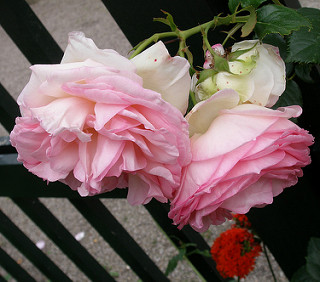

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

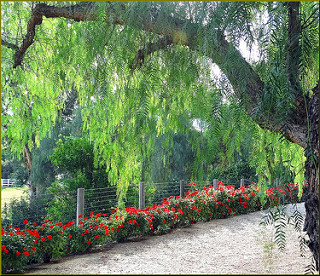

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

Cargar datos usando una utilidad de Keras

Crear conjunto de datos:

Definir parametros para el cargador

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Son buenas practicas el usar una division de validacion al desarrollar su modelo. el 80% para entrenamiento y el 20% para la validacion.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Se puede ver los nombrer de clase en el atributo class_names 

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


para visualizar los datos se usa matplotlib.pyplot

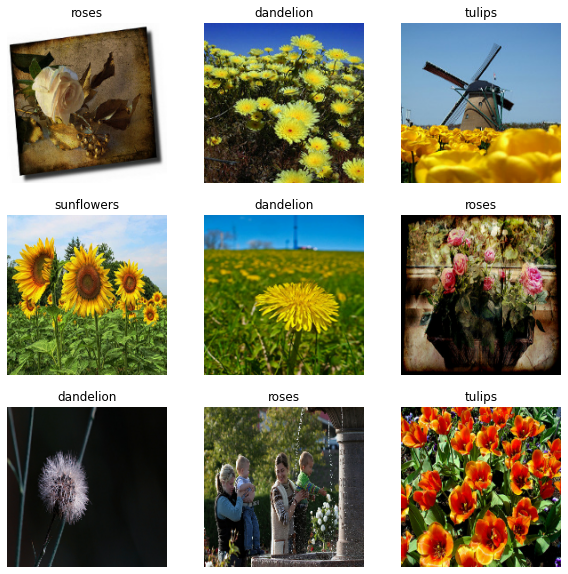

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Se puede entrenar un modelo sando estos conjuntos pasandoselos a model.fit. Tambien se puede iterar manualmente sobre el conjunto de datos y recuperar lotes de imagenes.

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


image_batch es un tensor de la forma (32, 180, 180, 3) . Este es un lote de 32 imágenes de forma 180x180x3 (la última dimensión se refiere a los canales de color RGB). El label_batch es un tensor de la forma (32,) , estas son las etiquetas correspondientes a las 32 imágenes.

Estandarizar los datos

Los valores del canal RGB están en el rango [0, 255] . Esto no es ideal para una red neuronal; en general, debe buscar que sus valores de entrada sean pequeños.

Aquí, estandarizará los valores para que estén en el rango [0, 1] usando tf.keras.layers.Rescaling :

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)


Esta capa se puede usar de dos modos distintos.

Se puede aplicar directamente al conjunto de datos de entrenamiento, train_ds, usando la funcion Dataset.map:


In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


O puede incluir la capa dentro de la definición de su modelo para simplificar la implementación. Aquí utilizará el segundo enfoque.

Nota: si desea escalar los valores de píxeles a [-1,1] , puede escribir tf.keras.layers.Rescaling(1./127.5, offset=-1)

Nota: anteriormente cambiaste el tamaño de las imágenes usando el argumento image_size de tf.keras.utils.image_dataset_from_directory . Si también desea incluir la lógica de cambio de tamaño en su modelo, puede usar la capa tf.keras.layers.Resizing .

Configurar el conjunto de datos para el rendimiento
Asegurémonos de utilizar la captación previa almacenada en búfer para que pueda obtener datos del disco sin que la E/S se convierta en un bloqueo. Estos son dos métodos importantes que debe usar al cargar datos:

Dataset.cache mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en la memoria, también puede usar este método para crear un caché en disco de alto rendimiento.

Dataset.prefetch superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)